# Fraud Detection: Comparative Visualization Notebook

## Overview
This notebook supports our milestone report by:
- Visualizing the class imbalance
- PCA projection to assess cluster separation
- Comparing Isolation Forest, Autoencoder, and LSTM Autoencoder
- Displaying model scores: precision, recall, F1
- Visualizing ROC, PR curves, and confusion matrices

## Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from IPython.display import Image, display
from pathlib import Path

Path("../reports").mkdir(exist_ok=True)

ModuleNotFoundError: No module named 'tensorflow.keras'

## Load Dataset

In [3]:
df = pd.read_csv("../data/creditcard.csv")
df['ClassLabel'] = df['Class'].map({0: 'Non-Fraud', 1: 'Fraud'})
X = df.drop(["Class", "ClassLabel", "Time"], axis=1)
y = df["Class"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape(-1, 1, X_scaled.shape[1])

## Class Distribution

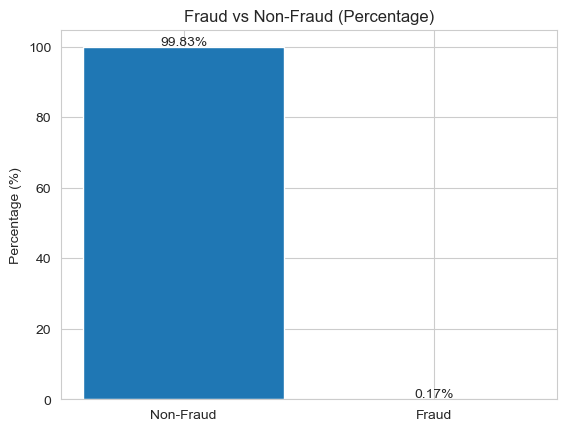

In [4]:
sns.set_style("whitegrid")
counts = df['ClassLabel'].value_counts(normalize=True) * 100
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values, color=["C0", "C1"])
ax.set_ylabel("Percentage (%)")
ax.set_title("Fraud vs Non-Fraud (Percentage)")
for i, val in enumerate(counts.values):
    ax.text(i, val + 0.5, f"{val:.2f}%", ha="center")
plt.savefig("../reports/fraud_distribution_percent.png")
plt.show()

## PCA Projection

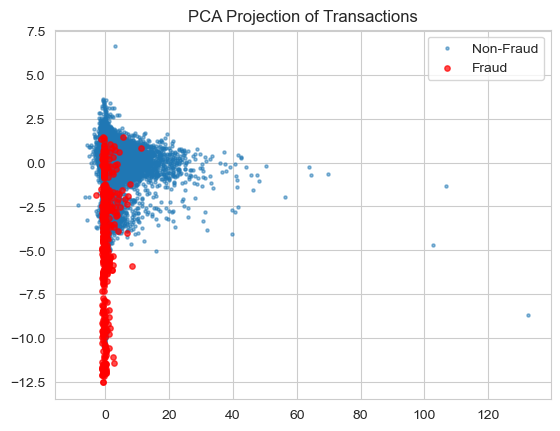

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
fig, ax = plt.subplots()
ax.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], s=5, alpha=0.5, label='Non-Fraud')
ax.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], s=15, alpha=0.7, label='Fraud', c='r')
ax.set_title("PCA Projection of Transactions")
ax.legend()
plt.savefig("../reports/pca_projection.png")
plt.show()

## Load Models

In [ ]:
import joblib
import tensorflow as tf
from keras.src.legacy.saving import legacy_h5_format

# Define custom_objects to handle both 'mse' and 'Orthogonal'
custom_objects = {
    'mse': tf.keras.losses.MeanSquaredError(),
    'Orthogonal': tf.keras.initializers.Orthogonal()
}

# Load models using legacy loader with custom objects
iso_model = joblib.load("../models/isolation_forest.pkl")
ae_model = legacy_h5_format.load_model_from_hdf5("../models/best_autoencoder_model.h5", compile=False, custom_objects=custom_objects)
lstm_model = legacy_h5_format.load_model_from_hdf5("../models/best_lstm_autoencoder_model.h5", compile=False, custom_objects=custom_objects)

# Recompile manually
ae_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
lstm_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

ValueError: ('Unrecognized keyword arguments:', dict_keys(['batch_shape']))

## Predictions & Thresholds

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_pred_iforest = (iso_model.predict(X_scaled_df) == -1).astype(int)

recon_ae = ae_model.predict(X_scaled)
errors_ae = np.mean(np.square(X_scaled - recon_ae), axis=1)
ae_thresh = np.percentile(errors_ae, 95)
y_pred_ae = (errors_ae > ae_thresh).astype(int)

recon_lstm = lstm_model.predict(X_seq)
errors_lstm = np.mean(np.square(X_seq - recon_lstm), axis=(1, 2))
lstm_thresh = np.percentile(errors_lstm, 95)
y_pred_lstm = (errors_lstm > lstm_thresh).astype(int)

## Model Comparison

In [ ]:
def get_metrics(y_true, y_pred):
    return [
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]

m_iforest = get_metrics(y, y_pred_iforest)
m_ae = get_metrics(y, y_pred_ae)
m_lstm = get_metrics(y, y_pred_lstm)

labels = ["Precision", "Recall", "F1-score"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, m_iforest, width, label="Isolation Forest")
ax.bar(x, m_ae, width, label="Autoencoder")
ax.bar(x + width, m_lstm, width, label="LSTM Autoencoder")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.title("Model Comparison")
plt.savefig("../reports/model_bar_comparison.png")
plt.show()

## Metrics Table

In [ ]:
df_metrics = pd.DataFrame({
    "Isolation Forest": m_iforest,
    "Autoencoder": m_ae,
    "LSTM Autoencoder": m_lstm
}, index=labels).round(3)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_metrics.values,
                 colLabels=df_metrics.columns,
                 rowLabels=df_metrics.index,
                 loc='center')
table.scale(1, 2)
plt.title("Model Performance Summary")
plt.savefig("../reports/model_metrics_table.png", bbox_inches='tight')
plt.show()

## Confusion Matrices

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models = ["Isolation Forest", "Autoencoder", "LSTM Autoencoder"]
preds = [y_pred_iforest, y_pred_ae, y_pred_lstm]

for ax, title, pred in zip(axes, models, preds):
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.savefig("../reports/confusion_matrices.png")
plt.show()

## ROC and PR Curves

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for name, scores in zip(models, [errors_ae, errors_lstm, -iso_model.decision_function(X_scaled_df)]):
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title("ROC Curves")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

for name, scores in zip(models, [errors_ae, errors_lstm, -iso_model.decision_function(X_scaled_df)]):
    precision, recall, _ = precision_recall_curve(y, scores)
    axs[1].plot(recall, precision, label=name)
axs[1].set_title("Precision-Recall Curves")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

plt.savefig("../reports/roc_pr_curves.png")
plt.show()

## Autoencoder and LSTM Loss Curve

In [ ]:
display(Image("../reports/autoencoder_loss_curve.png"))
display(Image("../reports/lstm_autoencoder_loss_curve.png"))